In [1]:
# Some Preliminary imports and so on
import numpy as np 
import matplotlib.pyplot as plt 
from astropy.io import fits

from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

# Exploring simulated model atmospheres and their synthetic spectra

### In this jupyter notebook we will:
- Familiarize ourselves with a simulated 3D model of the solar photosphere, obtained with MURaM code (Rempel 2014)
- Familiarize ourselves with the synthetic spectrum of two iron spectral lines around 630 nm, calculated from this cube 
- Explore the relationship between the cube and the spectrum
- Prepare the data for the training in the simple DNN we will use later

The cube can be downloaded here:

https://drive.google.com/drive/folders/12S8h_zv2z8BwMg83JLVk04O9ke6Jy8bT?usp=sharing

## Simulation of the solar photosphere:

### What we have here:

A 4-D structure encoding 3D variation of different physical quantities in a path of the solar photosphere. 
Dimensions are as follows: 
- Parameter : 11 diferent physical parameters, we will only care about the temperature and velocity to begin with 
- Depth: 71 discrete depth points in the optical depth scale (recall the lecture)
- NX: 768 horizontal points, 16 km spacing 
- NY: 768 horizontal points alon different axis, 16 km spacing

In [2]:
# Open the atmos file and grab the data

atmos = fits.open("/home/milic/data/muram_from_rebecca/disk_center/atmos/qs_ph_disk_center_1_1_tau.fits")[0].data
atmos.shape

(11, 71, 768, 768)

In [3]:
# Copy what we need, delete the rest from memory

T = np.copy(atmos[1])
vz = np.copy(atmos[5])
tau = np.copy(atmos[0,:,0,0]) # this is identical for all the columns in this specific cube
print(T.shape)
print(vz.shape)
del(atmos)


(71, 768, 768)
(71, 768, 768)


In [4]:
# I personally prefer to order things as x,y,z (even though the last coordinate is not exactly z)

T = T.transpose(1,2,0)
vz = vz.transpose(1,2,0)

Text(0, 0.5, 'Temperature [K]')

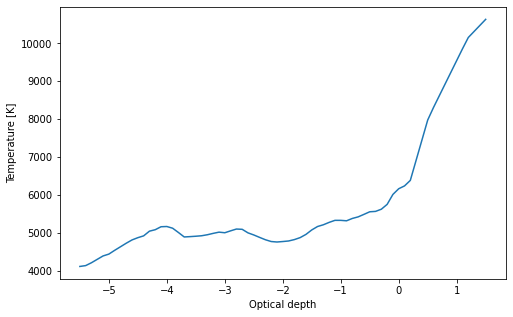

In [5]:
# Let's plot one example temperature structure and discuss briefly the axes:
i = 144
j = 256

plt.figure(figsize=[8,5])
plt.plot(tau, T[i,j])
plt.xlabel("Optical depth")
plt.ylabel("Temperature [K]")



### Discuss this for a while: 

- What is optical depth ($\tau$), what does it mean? Where is zero? What layers do the other values correspond to
- What are the ranges for the temperature? How does the gas behave at these temperatures. 
- Why is the temperature (generally) decreasing toward lower optical depths (top of the photosphere)

### After that, let's plot several different atmospheric stratifications:

Text(0, 0.5, 'Temperature [K]')

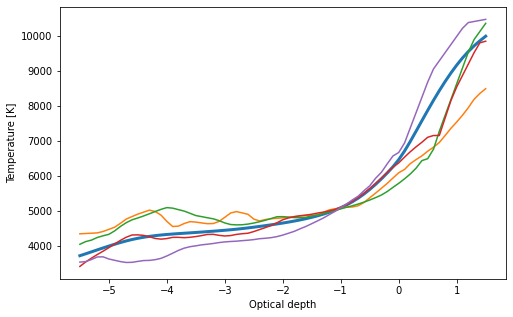

In [6]:
# I will actually first find the "mean" temperature stratification and then overplot some random ones 
T_mean = np.mean(T,axis=(0,1))

plt.figure(figsize=[8,5])
plt.plot(tau, T_mean, linewidth=3)
plt.plot(tau, T[133,266])
plt.plot(tau, T[179,519])
plt.plot(tau, T[0,100])
plt.plot(tau, T[333,111])
plt.xlabel("Optical depth")
plt.ylabel("Temperature [K]")

### This does not really allow us to see the structure of the simulation. 

Let's do this differently, let's plot the temperature structure at different depths:

$\log \tau = 0$ - bottom of the photosphere

$\log \tau = -1$ - mid photosphere

$\log \tau = -2$ - top photosphere

$\log \tau = -3$ - temperature minimum


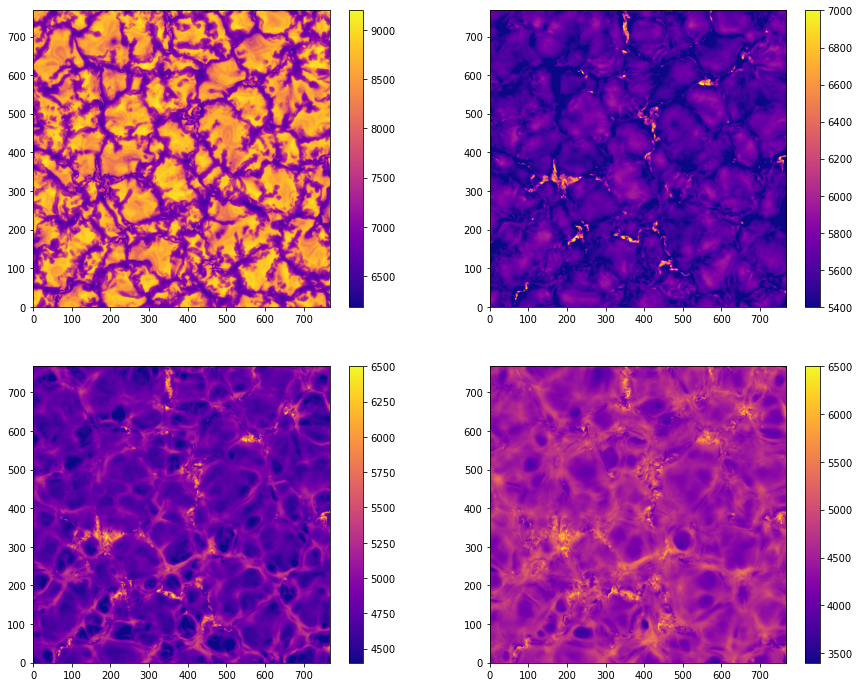

In [7]:
plt.figure(figsize=[15,12])
plt.subplot(221)
plt.imshow(T[:,:,10].T,cmap='plasma',origin='lower')
plt.colorbar()
plt.subplot(222)
plt.imshow(T[:,:,20].T,cmap='plasma',vmin=5400,vmax=7000, origin='lower')
plt.colorbar()
plt.subplot(223)
plt.imshow(T[:,:,30].T,cmap='plasma',vmin=4400,vmax=6500, origin='lower')
plt.colorbar()
plt.subplot(224)
plt.imshow(T[:,:,40].T,cmap='plasma',vmin=3400,vmax=6500, origin='lower')
plt.colorbar()

In [8]:
### Discuss what we see on these images and why is the temperature structure the way it is. 

### Now, let's do the same with the LOS velocity and analyze that:

vz = vz / 1E5 # convert cm/s to km/s

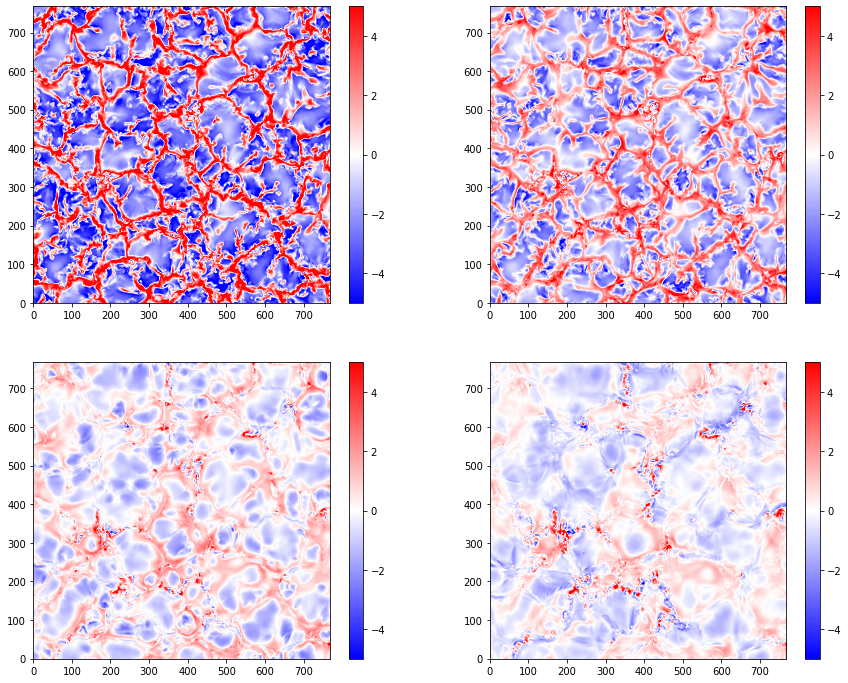

In [9]:
plt.figure(figsize=[15,12])
plt.subplot(221)
plt.imshow(vz[:,:,10].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(222)
plt.imshow(vz[:,:,20].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(223)
plt.imshow(vz[:,:,30].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.colorbar()
plt.subplot(224)
plt.imshow(vz[:,:,40].T,cmap='bwr',origin='lower',vmin=-5,vmax=5)
plt.colorbar()

### Questions: 

- What do these positive and negative velocities refer to?
- Do they fit with the temperature structure we are seeing above? 
- Why are we only interested line-of-sight velocities? Velocity is vector, after all! 


#### Discuss these for a while.

#### Plot T vs V scatter plot at the photospheric heights


Text(0, 0.5, 'Velocity')

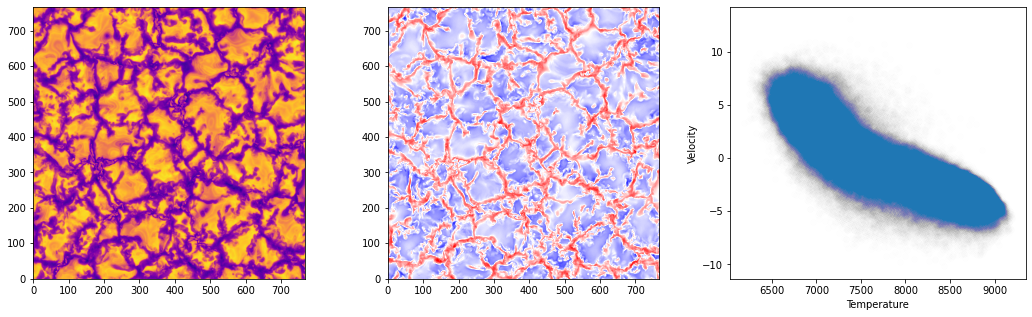

In [16]:
plt.figure(figsize=[18,5])
plt.subplot(131)
plt.imshow(T[:,:,10].T,cmap='plasma',origin='lower')
plt.subplot(132)
plt.imshow(vz[:,:,10].T,cmap='bwr',origin='lower',vmin=-10,vmax=10)
plt.subplot(133)
plt.plot(T[:,:,10].flatten(),vz[:,:,10].flatten(),'o',alpha=0.002)
plt.xlabel("Temperature")
plt.ylabel("Velocity")

Text(0, 0.5, 'Velocity')

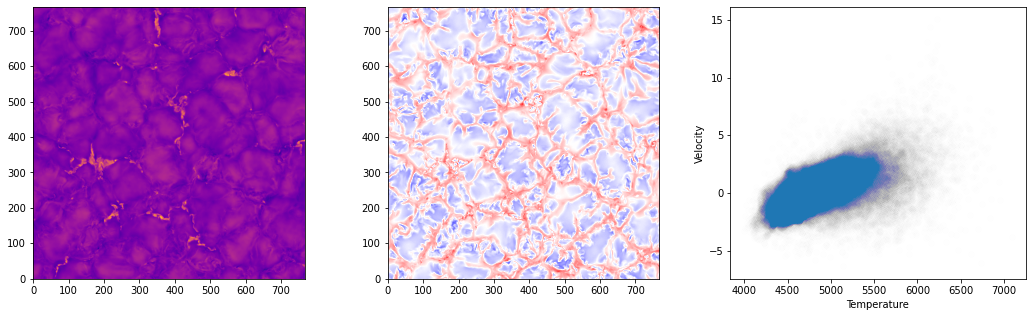

In [19]:
# Now the same for the other height

plt.figure(figsize=[18,5])
plt.subplot(131)
plt.imshow(T[:,:,20].T,cmap='plasma',origin='lower')
plt.subplot(132)
plt.imshow(vz[:,:,20].T,cmap='bwr',origin='lower',vmin=-10,vmax=10)
plt.subplot(133)
plt.plot(T[:,:,30].flatten(),vz[:,:,30].flatten(),'o',alpha=0.002)
plt.xlabel("Temperature")
plt.ylabel("Velocity")

### Keep in mind one thing: We DO imagine the Sun looks like this, but we cannot measure any of these directly!

### What can we measure then? The spectra:

Each of the pixels in this image can be imagined as a 1D atmosphere with it's own depth structure. 

According to the presentation we just had, the light is transported through this atmosphere and a spectrum is formed according to the radiative transfer equation:

## $$ \cos \theta \frac{dI_\lambda(z)}{dz} = - \chi_\lambda(z) I_\lambda(z) + j_\lambda(z) $$

We only see the solution of this equation: $I(\lambda)$, but the solution depends on the depth and wavelength variation of the coefficients $\chi$ and $j$.

We have some simulated pieces of the spectra prepared, let's see how they look like.



In [23]:
stokes = fits.open("/home/milic/data/muram_from_rebecca/hinode_wvl/qs_ph_disk_center_synth.hinodewvl.fits")[0].data

In [24]:
stokes.shape

(768, 768, 4, 112)

In [25]:
# Let's again, plot some example spectra, side by side with their atmospheric structures:

Text(0, 0.5, 'Stokes I')

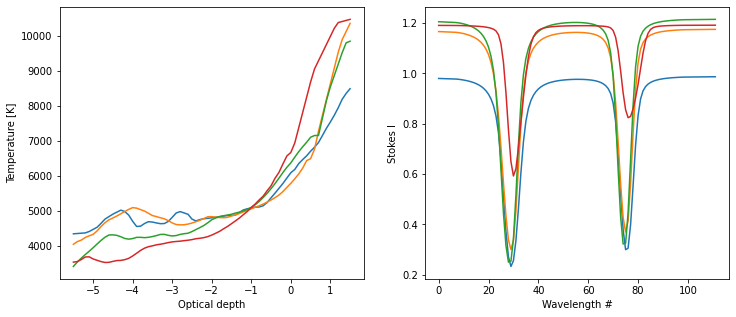

In [28]:
plt.figure(figsize=[12,5])
plt.subplot(121)
plt.plot(tau, T[133,266])
plt.plot(tau, T[179,519])
plt.plot(tau, T[0,100])
plt.plot(tau, T[333,111])
plt.xlabel("Optical depth")
plt.ylabel("Temperature [K]")

plt.subplot(122)
plt.plot(stokes[133,266,0])
plt.plot(stokes[179,519,0])
plt.plot(stokes[0,100,0])
plt.plot(stokes[333,111,0])
plt.xlabel("Wavelength #")
plt.ylabel("Stokes I")

### What do you remember from the earlier lecture? Can you relate differences in the atmospheres to the difference in the spectral lines? 

.

.

.

.

### Now, let's plot images at different wavelengths. Let's zoom a bit into a line and pick some interesting wavelength points: 

(5.0, 30.0)

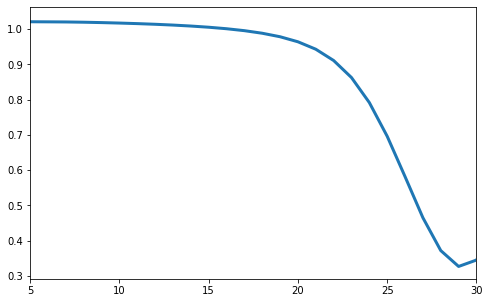

In [31]:
# Find the mean spectrum
mean_spectrum = np.mean(stokes, axis=(0,1))

plt.figure(figsize=[8,5])
plt.plot(mean_spectrum[0], linewidth=3)
plt.xlim([5,30])

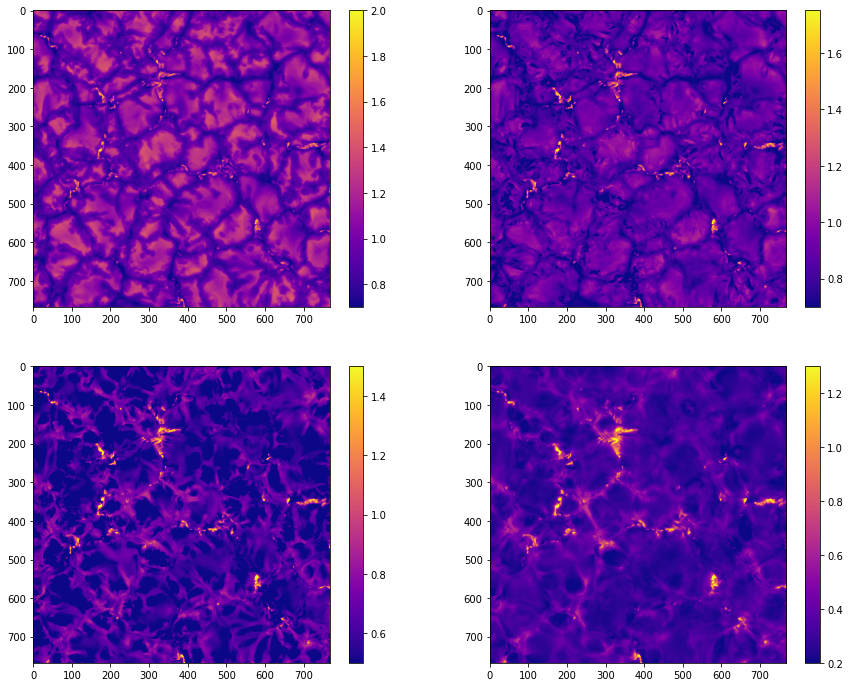

In [37]:
plt.figure(figsize=[15,12])
plt.subplot(221)
plt.imshow(stokes[:,:,0,10].T,cmap='plasma',vmin=0.7,vmax=2.0)
plt.colorbar()
plt.subplot(222)
plt.imshow(stokes[:,:,0,23].T,cmap='plasma',vmin=0.7,vmax=1.75)
plt.colorbar()
plt.subplot(223)
plt.imshow(stokes[:,:,0,26].T,cmap='plasma',vmin=0.5,vmax=1.5)
plt.colorbar()
plt.subplot(224)
plt.imshow(stokes[:,:,0,29].T,cmap='plasma',vmin=0.2,vmax=1.3)
plt.colorbar()

### Scroll up. Compare the images at different wavelengths to the maps of the temperature at different layers.

#### Are they similar? - Yes, obviously

#### Why is this so? Can you relate it to what we covered in the lecture earlier? 

#### Is there a trivial way to just pick up a wavelength, where the intensity relates to the velocity? 

Above is actually a quite interesting question, that illustrates well the difference between correlation and causation. 

To understand better what I mean by this, let's plot the correlation between the continuum intensity and the velocity in the photosphere, how do you expect this to behave? 

~ Discuss a little bit before we do the plot ~ 








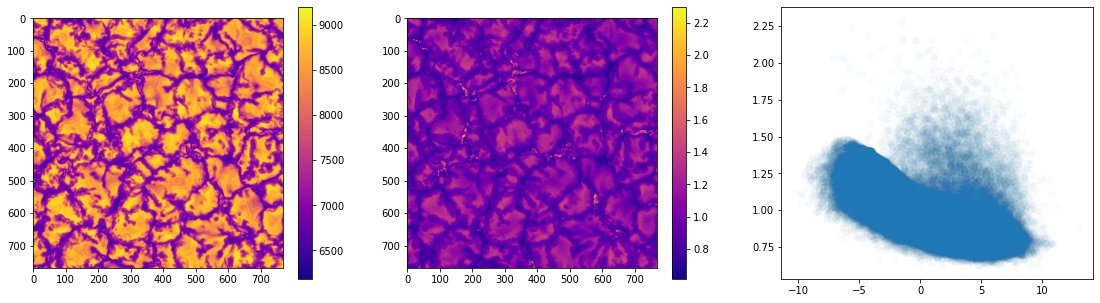

In [49]:
plt.figure(figsize=[19,5])
plt.subplot(131)
plt.imshow(T[:,:,10],cmap='plasma')
plt.colorbar()
plt.subplot(132)
plt.imshow(stokes[:,:,0,0].T,cmap='plasma')
plt.colorbar()
plt.subplot(133)
plt.plot(vz[:,:,10].flatten(), stokes[:,:,0,0].T.flatten(),'o',alpha=0.02)

In [50]:
# Mind the transpose thingy, fix this...

# Preparing the data for the NN training

### We are now going to do something fairly straightforward and technical. Normalize the spectra (input) and the temperature and velocity at few fixed heights (output), to the range 0,1 and write it to separate .fits files, so that we can train a network .

### With the little bit more advanced neural network architectures (that you probably know better than me), you can probably automatize this. 

### Also, batch normalization should (I think) get rid of many of these things for you automatically

In [51]:
### We will also make sure we save the normalizing quantities to the fits file so that we transform the outputs to the meaningful physical quantities.
### Very simple: 

In [57]:
spectrum_max = np.amax(stokes[:,:,0,:])
spectrum_min = np.amin(stokes[:,:,0,:])

spectrum_norm = (stokes[:,:,0,:] - spectrum_min) / (spectrum_max - spectrum_min)

spectrum_norm = spectrum_norm.reshape(-1,len(spectrum_norm[0,0]))

In [58]:
spectrum_norm.shape

(589824, 112)

In [60]:
spectrum_norm = spectrum_norm.astype("float32")

In [67]:
datahdu = fits.PrimaryHDU(spectrum_norm)
normhdu = fits.ImageHDU([spectrum_min, spectrum_max])

In [68]:
hdulist = fits.HDUList([datahdu, normhdu])
hdulist.writeto("normalized_data.fits",overwrite=True)